In [1]:
import msprime
import tskit
import numpy as np

import os
import subprocess

import pandas as pd

import math 
import statistics

import seaborn as sns
from IPython.display import SVG, set_matplotlib_formats
from matplotlib import pyplot as plt

from collections import Counter

### Testing the expected branch length under the IM model

##### Set up a branch type dictionary for the unphased unrooted IM model
##### Keys are lists of lineages which share a derived mutation, values are mutation types (see Laetsch et al. 2023)

In [2]:
HetATypes = [
    [0],
    [1],
    [0,2,3],
    [1,2,3]
]
HetBTypes = [
    [2],
    [3],
    [0,1,2],
    [0,1,3]
]
FixedDiffs = [
    [0,1],
    [2,3]
]
HetABTypes = [
    [0,2],
    [0,3],
    [1,2],
    [1,3]
]

mutTypeDict = {(0,1,2,3):None};
for ls in HetATypes:
    mutTypeDict[tuple(sorted(ls))] = "hetA"
for ls in HetBTypes:
    mutTypeDict[tuple(sorted(ls))] = "hetB"
for ls in HetABTypes:
    mutTypeDict[tuple(sorted(ls))] = "hetAB"
for ls in FixedDiffs:
    mutTypeDict[tuple(sorted(ls))] = "FD"

mutTypeDict


{(0, 1, 2, 3): None,
 (0,): 'hetA',
 (1,): 'hetA',
 (0, 2, 3): 'hetA',
 (1, 2, 3): 'hetA',
 (2,): 'hetB',
 (3,): 'hetB',
 (0, 1, 2): 'hetB',
 (0, 1, 3): 'hetB',
 (0, 2): 'hetAB',
 (0, 3): 'hetAB',
 (1, 2): 'hetAB',
 (1, 3): 'hetAB',
 (0, 1): 'FD',
 (2, 3): 'FD'}

In [3]:
def record_branch_lengths(mts_list):

    a_0_lengths = []
    b_0_lengths = []

    a_1_lengths = []
    b_1_lengths = []

    a_2_lengths = []
    b_2_lengths = []
    
    for mts in mts_list:

        tree = mts.at(block_length / 2) # assuming no recombination in a block, it doesn't matter where we sample from
     
        tempList = []
        for node in tree.nodes():
            leaves = tuple(sorted(list(tree.leaves(node))))
            mutType = mutTypeDict[leaves]
            length = tree.get_branch_length(node)
            tempList.append([mutType,length])
    
        # calculate the total length of hetA and hetB type branches in this tree
        a_length = sum([y for x,y in tempList if x=='hetA'])
        b_length = sum([y for x,y in tempList if x=='hetB'])
    
        # record the hetA and hetB branch lengths for all non-recombining blocks
        a_0_lengths.append(a_length)
        b_0_lengths.append(b_length)
    
    
        # if the topology is incongruent, 
        if 'hetAB' in [a for (a,b) in tempList]:
            
            #store the hetA and hetB branch lengths for this tree conditioned on incongruence
            a_1_lengths.append(a_length)
            b_1_lengths.append(b_length)
    
            # given incongruence, check if there is a hetAB mutation present within the block
            has_ab_mut = False
            muts = tree.mutations()
            for mut in muts:
                # get the node below the mutation and check the branch type (mutType) of the mutation
                node1 = mut.node
                leaves = tuple(sorted(list(tree.leaves(node1))))
                mutType = mutTypeDict[leaves]
                # if the mutation is hetAB
                if mutType == 'hetAB':
                    has_ab_mut = True
                    break
                            
            # conditioned on a hetAB mutation in the block, record the hetA and hetB branch lengths 
            if has_ab_mut:
                a_2_lengths.append(a_length)
                b_2_lengths.append(b_length)

    return a_0_lengths, b_0_lengths, a_1_lengths, b_1_lengths, a_2_lengths, b_2_lengths

In [4]:
def calculate_asymmetry(a_list, b_list):
    
    a_total = sum(a_list)
    b_total = sum(b_list)

    asymm = (a_total - b_total) / (a_total + b_total)

    return asymm

In [5]:
def block_jackknife(a_list, b_list, jk_block):
    #print("trimming {} sims...".format(len(a_list) % jk_block))
    total_jk_blocks = int((len(a_list) - (len(a_list) % jk_block)) / jk_block)
    if total_jk_blocks < 2:
        #print("not enough blocks for jackknife")
        overall_estimate = calculate_asymmetry(a_list, b_list)
        return [-1, overall_estimate, 1]
    #print("total of {} jk blocks".format(total_jk_blocks))
    trimmed_a_list = a_list[:total_jk_blocks * jk_block]
    trimmed_b_list = b_list[:total_jk_blocks * jk_block]
    blocked_a_list = np.mean(trimmed_a_list.reshape(-1, jk_block), axis=1)
    blocked_b_list = np.mean(trimmed_b_list.reshape(-1, jk_block), axis=1)
    overall_estimate = calculate_asymmetry(blocked_a_list, blocked_b_list)
    n = total_jk_blocks
    pseudo_estimates = []
    for i in range(0, n):
        retained_a_blocks = np.delete(blocked_a_list, i)
        retained_b_blocks = np.delete(blocked_b_list, i)
        retained_blocks_estimate = calculate_asymmetry(retained_a_blocks, retained_b_blocks)
        pseudo_estimate = (n * overall_estimate) - ((n - 1) * retained_blocks_estimate)
        pseudo_estimates.append(pseudo_estimate)
    pseudovalue_variance = sum([(e - overall_estimate)**2 for e in pseudo_estimates]) / (n - 1)
    lower_CI = overall_estimate - (1.96 * math.sqrt(pseudovalue_variance / n))
    higher_CI = overall_estimate + (1.96 * math.sqrt(pseudovalue_variance / n))
    return [lower_CI, overall_estimate, higher_CI]

##### Here we simulate sequences with recombination and calculate A_m across varying block sizes. The demography is for Odocoileus virginianus (WTD) and Odocoileus hemionus (MD), inferred by Kessler and Shafer (2024). This demography is for three populations (presented in Figure 4a of Kessler and Shafer 2024), and we sample lineages from two of the populations (WTD_ML and MD).

jack-knifing...


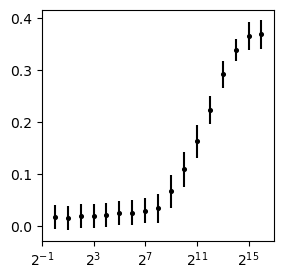

CPU times: total: 26 s
Wall time: 30.5 s


In [6]:
%%time

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

mu = 1.23e-8
r = 1.04e-8

L = 65_536
a_results_dict = {}
b_results_dict = {}
for dist in [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16_384, 32_768, 65_536]:
    a_results_dict[dist] = np.array([], dtype=np.float64)
    b_results_dict[dist] = np.array([], dtype=np.float64)


def a_b_from_tree(tree):
    tempList = []
    for node in tree.nodes():
        leaves = tuple(sorted(list(tree.leaves(node))))
        mutType = mutTypeDict[leaves]
        length = tree.get_branch_length(node)
        tempList.append([mutType,length])

    # calculate the total length of hetA and hetB type branches in this tree
    a_length = sum([y for x,y in tempList if x=='hetA'])
    b_length = sum([y for x,y in tempList if x=='hetB'])

    return a_length, b_length


for i in range(1, 101): # this would normally be 1001

    demography = msprime.Demography()
    demography.add_population(name="MD", initial_size=55_432)
    demography.add_population(name="WTD_ML", initial_size=171_380)
    demography.add_population(name="WTD_KEY", initial_size=19_344)
    demography.add_population(name="WTD_ANC", initial_size = 397_956)
    demography.add_population(name="ANC_REF", initial_size = 99_000) # this was an approximation based on info in the table, and I assumed it was for ultiamte ancestor
    
    demography.set_symmetric_migration_rate(populations=["MD","WTD_ML"],rate = 4.4e-6) 
    demography.set_symmetric_migration_rate(populations=["WTD_KEY","WTD_ML"], rate = 1.1e-5)  
    # I divided the values they reported by two, assuming that they reported years and NOT generations:


    demography.add_symmetric_migration_rate_change(time=6_725/2, populations=["MD","WTD_ML"], rate = 0.0) 
    demography.add_symmetric_migration_rate_change(time=6_725/2, populations=["WTD_KEY","WTD_ML"], rate = 0.0)
    demography.add_population_split(time = (54_196/2), derived = ["WTD_ML","WTD_KEY"],ancestral = "WTD_ANC")
    demography.add_population_split(time = (280_277/2), derived = ["MD","WTD_ANC"], ancestral = "ANC_REF")

    ts = msprime.sim_ancestry(
        samples={"WTD_ML": 1, "MD": 1}, 
        demography=demography,
        ploidy=2,
        recombination_rate=r,
        sequence_length=L,
        discrete_genome=True, # means genelogies have defined coords
        random_seed = 44+i,
        record_migrations=True
    )

    mt_ts = msprime.sim_mutations(ts, rate=mu, discrete_genome=False, random_seed = 44+i)

    seq_a_length = []
    seq_b_length = []
    hetAB = [0] * L
    
    for tree in mt_ts.trees():
        
        start = tree.interval.left
        end = tree.interval.right
        span = int(end - start)
        a_length, b_length = a_b_from_tree(tree)
        seq_a_length = seq_a_length + ([a_length] * span)
        seq_b_length = seq_b_length + ([b_length] * span)
        for site in tree.sites():
            mut_pos = int(site.position) # effectively assumes infinite sites
            leaves = tuple(sorted(list(tree.leaves(site.mutations[0].node))))
            mutType = mutTypeDict[leaves]
            if mutType == "hetAB":
                hetAB[mut_pos] = 1

    
    for dist in a_results_dict.keys():
        for interval_start in range(0, L, dist):
            interval_hetAB = hetAB[interval_start:interval_start+dist]
            if sum(interval_hetAB) > 0:
                interval_res_a = seq_a_length[interval_start:interval_start+dist]
                interval_res_b = seq_b_length[interval_start:interval_start+dist]
                interval_a = sum(interval_res_a) / len(interval_res_a)
                interval_b = sum(interval_res_b) / len(interval_res_b)
                a_results_dict[dist] = np.append(a_results_dict[dist], np.array([interval_a]))
                b_results_dict[dist] = np.append(b_results_dict[dist], np.array([interval_b]))


    if i % 100 == 0 and i > 0:


        dist_list = []
        asymm_list_l = []
        asymm_list_p = []
        asymm_list_u = []
        topology_list = []
        
        print("jack-knifing...")
        
        for dist in a_results_dict.keys():
            if len(a_results_dict[dist]) > 0:
                jk_block = int(round((len(a_results_dict[dist]) / 25), 0)) 
                #print(jk_block)
                dist_list.append(dist)
                lower, point, upper = block_jackknife(a_results_dict[dist], b_results_dict[dist], jk_block)
                asymm_list_l.append(lower)
                asymm_list_p.append(point)
                asymm_list_u.append(upper)
                
        fig, ax = plt.subplots()
        fig.set_size_inches(3, 3)
        ax.scatter(x = dist_list, y = asymm_list_p, s=7, color="k")
        ax.errorbar(x = dist_list, y = asymm_list_p, yerr = np.subtract(asymm_list_p, asymm_list_l), color="k", ls='none')
        ax.xaxis.set_major_formatter(ScalarFormatter())
        ax.set_xscale('log', base=2)
        ax.set_xlim(0.5, 2*L)
        #ax.set_ylim(0, 0.025)
        ax.set_xscale('log', base=2)
        plt.show()


In [7]:
# print results
print(dist_list)
print()
print(asymm_list_l)
print()
print(asymm_list_p)
print()
print(asymm_list_u)
print()


[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536]

[-0.0060318749981214635, -0.007812742105182431, -0.003561988867412446, -0.0038257217825323035, -0.002077250488092316, 0.0013110680034461066, 0.001742306864985884, 0.0054334208467549765, 0.006893691209508158, 0.03565065720396523, 0.07530574333163073, 0.13197189033057338, 0.196417921434047, 0.2664444175708427, 0.317203428032851, 0.33960518163413966, 0.34132368347002773]

[0.01703913665852097, 0.015389431636658605, 0.019410525656074432, 0.0189445188026648, 0.020799853444913922, 0.024424218382662517, 0.025578758710528973, 0.029400398932748553, 0.03453060146544586, 0.06720270754627866, 0.10943664124656059, 0.16301672243747342, 0.22377534442873545, 0.29227197623948015, 0.33892692251961265, 0.3659471354553237, 0.36886268351456664]

[0.04011014831516341, 0.03859160537849964, 0.04238304017956131, 0.0417147593878619, 0.043676957377920156, 0.04753736876187893, 0.049415210556072064, 0.053367377018742126, 0.062167

In [8]:
# print results for plotting in Mathematica
for i, dist in enumerate(dist_list):
    print("{}{}, {}{}, ".format("{", i, asymm_list_p[i], "}"), end="")

{0, 0.01703913665852097}, {1, 0.015389431636658605}, {2, 0.019410525656074432}, {3, 0.0189445188026648}, {4, 0.020799853444913922}, {5, 0.024424218382662517}, {6, 0.025578758710528973}, {7, 0.029400398932748553}, {8, 0.03453060146544586}, {9, 0.06720270754627866}, {10, 0.10943664124656059}, {11, 0.16301672243747342}, {12, 0.22377534442873545}, {13, 0.29227197623948015}, {14, 0.33892692251961265}, {15, 0.3659471354553237}, {16, 0.36886268351456664}, 

In [9]:
# print results for plotting in Mathematica
for i, l, u in zip([k for k in range(0, 17)], asymm_list_l, asymm_list_u):
   print("Line{}{}, {}{}{}, {}{}".format("[{{", i, l, "}, {", i, u, "}}], "), end="")

Line[{{0, -0.0060318749981214635}, {0, 0.04011014831516341}}], Line[{{1, -0.007812742105182431}, {1, 0.03859160537849964}}], Line[{{2, -0.003561988867412446}, {2, 0.04238304017956131}}], Line[{{3, -0.0038257217825323035}, {3, 0.0417147593878619}}], Line[{{4, -0.002077250488092316}, {4, 0.043676957377920156}}], Line[{{5, 0.0013110680034461066}, {5, 0.04753736876187893}}], Line[{{6, 0.001742306864985884}, {6, 0.049415210556072064}}], Line[{{7, 0.0054334208467549765}, {7, 0.053367377018742126}}], Line[{{8, 0.006893691209508158}, {8, 0.06216751172138357}}], Line[{{9, 0.03565065720396523}, {9, 0.09875475788859209}}], Line[{{10, 0.07530574333163073}, {10, 0.14356753916149045}}], Line[{{11, 0.13197189033057338}, {11, 0.19406155454437346}}], Line[{{12, 0.196417921434047}, {12, 0.25113276742342394}}], Line[{{13, 0.2664444175708427}, {13, 0.3180995349081176}}], Line[{{14, 0.317203428032851}, {14, 0.3606504170063743}}], Line[{{15, 0.33960518163413966}, {15, 0.39228908927650774}}], Line[{{16, 0.34